### Introduction to Machine Learning (Spring Semester 2020)
# Long Term Credit Rating Projection
#### submitted by: Fabian Künzler, Rafael Grünenfelder, Andrin Plüss, Bela Koch



In [1]:
# comment the lines below in if there is a module not found error and replace tensorflow with the library missing
# this will install the library in the python executable used by jupyter
#import sys
#!{sys.executable} -m pip install tensorflow
# for visualization we used the python library mlxtend
# please comment in following line if not installed already (import sys above has to be commented in too)
#!{sys.executable} -m pip install mlxtend
import pandas as pd
import numpy as np
np.random.seed(0)
from functools import partial
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14
import statsmodels.graphics.tsaplots as smf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import os
import re
from sklearn import preprocessing as pp
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#ignore warnings because of soon to be depricated versions
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
tf.random.set_seed(0)

## Data Preprocessing
### Combine tables
The first task which needs to be completed first is to merge the tables with the economic data and the table with ratings. Before we can do this we need to choose the selected columns and do so reformatting. For example do we have to convert the monthly ratings into quarterly ratings.

Below you see the main function which is responsible for combining the different tables

In [2]:
def merge_tables(execute = True):

    if not execute: return

    df_ratings = pd.DataFrame(pd.read_csv(os.path.join(relative_path_data, __file_ratings__), sep=',', error_bad_lines=False))
    df_economic_fundamental_data = pd.DataFrame(pd.read_csv(os.path.join(relative_path_economic_data, __file_economic_fundamentals__), sep=',', error_bad_lines=False, dtype='unicode'))
    df_economic_ratios_data = pd.DataFrame(pd.read_csv(os.path.join(relative_path_economic_data, __file_economic_ratios__), sep=',', error_bad_lines=False, dtype='unicode'))

    # The date is formatted and its column is renamed to date.
    # Additionally we add a column with a constant (1).
    df_economic_fundamental_data = format_date_fundamentals(df_economic_fundamental_data)
    df_economic_fundamental_data['const'] = 1 
    # The date is formatted and its column is renamed to date.
    # Additionally the ratios are transformed from monthly to quarterly.
    df_economic_ratios_data = format_date_ratios(df_economic_ratios_data)

    # We read all calculations and column names which have been selected to be in the final
    # dataframe for the evaluation by the different models and select the calculations.
    evaluated_columns = read_columns()
    selected_columns = evaluated_columns[1]

    # Now we sort the columns according to their dataframe (fundamental, financial ratio)
    tuple_selected = sort_columns(df_economic_fundamental_data, selected_columns)

    # merges the tables together
    result = merge_tables_correctly(tuple_selected, df_ratings, df_economic_fundamental_data, df_economic_ratios_data)

    # execute calculations and store the ratings in column ratings
    result = formatting_table(result, evaluated_columns[0])

    # write the result into the file quarterlyRatings.csv
    result.to_csv(os.path.join(relative_path_data, __file_ratings_quarterly__), index=False)

## Data Preprocessing
In this section, we preprocess our data in order to generate a features matrix and a response vector. <br>

In a first step, we merge the financial ratios, fundamental data and credit ratings dataframes into one combined table. The raw dataframes of financial ratios and fundamental data can be found in the *economicData* folder under *data* as *allFinancialRatios.csv* and *allFundamentals.csv*. The raw credit ratings dataframe can be found in the *data* folder as *ratingsByTic.csv*. The resulting table is then saved as *quarterlyRatings.csv* in the *data* folder. <br>

In a second step, we further prepare our data. We clean the previously merged table and eventually assign the ratings to the response vector *y* and the selected columns to the feature matrix *x*.

In a third step, we split our sample in a train and test set and standardize it.

### Merging tables
In this first step of data preprocessing, we merge the financial ratios, fundamental data and credit ratings dataframes into one combined table. To be specific, the algorithm first perceives the columns which are specified in the *selectedColumns.txt* file in the *economicData* folder under *data* file and only merges them in order to increase the efficiency. (Note: The *selectedColumns.txt* file contains the 15 features we use for our analysis. There are are two other txt files in that folder; one contains all 64 features with which we started our analysis, the other one contains the 10 most significant features.)

For our data to be timely compliant, we convert the monthly observations of financial ratios and credit ratings  into  quarterly  data  points.   This  conversion  assigns  the  mean  of  monthly  data during a business quarter to the quarterly data. The resulting table is then saved as *quarterlyRatings.csv* in the *data* folder.

The monthly ratings, the monthly financial ratios and the quarterly fundamental data are read from the local data-files. For reasons of performance and simplicity, the whole database of ratings and fundamentals has been downloaded from https://wrds-web.wharton.upenn.edu/wrds/query_forms/navigation.cfm?navId=83. Firstly, we specify the different data sources we use.

In [3]:
__file_ratings__ = 'ratingsByTic.csv'
__file_selected_economic_data__ = 'selectedParameters.csv'
__file_economic_fundamentals__ = 'allFundamentals.csv'
__file_economic_ratios__ = 'allFinancialRatios.csv'
__file_selected_columns__ = 'selectedColumns'
__file_ratings_quarterly__ = 'quarterlyRatings.csv'
relative_path_data = os.path.realpath('../docs/data')
relative_path_economic_data = os.path.realpath('../docs/data/economicData')

The **merge_tables** function is used to merge our tables. The function utilizes other functions, which are specified subsequently. For the sake of clarity we comment the functions within the code.

In [4]:
def merge_tables(execute = True):

    if not execute: return

    df_ratings = pd.DataFrame(pd.read_csv(os.path.join(relative_path_data, __file_ratings__), sep=',', error_bad_lines=False))
    df_economic_fundamental_data = pd.DataFrame(pd.read_csv(os.path.join(relative_path_economic_data, __file_economic_fundamentals__), sep=',', error_bad_lines=False, dtype='unicode'))
    df_economic_ratios_data = pd.DataFrame(pd.read_csv(os.path.join(relative_path_economic_data, __file_economic_ratios__), sep=',', error_bad_lines=False, dtype='unicode'))

    # The date is formatted and its column is renamed to date.
    # Additionally we add a column with a constant (1).
    df_economic_fundamental_data = format_date_fundamentals(df_economic_fundamental_data)
    df_economic_fundamental_data['const'] = 1 
    # The date is formatted and its column is renamed to date.
    # Additionally the ratios are transformed from monthly to quarterly.
    df_economic_ratios_data = format_date_ratios(df_economic_ratios_data)

    # We read all calculations and column names which have been selected to be in the final
    # dataframe for the evaluation by the different models and select the calculations.
    evaluated_columns = read_columns()
    selected_columns = evaluated_columns[1]

    # Now we sort the columns according to their dataframe (fundamental, financial ratio)
    tuple_selected = sort_columns(df_economic_fundamental_data, selected_columns)

    # merges the tables together
    result = merge_tables_correctly(tuple_selected, df_ratings, df_economic_fundamental_data, df_economic_ratios_data)

    # execute calculations and store the ratings in column ratings
    result = formatting_table(result, evaluated_columns[0])

    # write the result into the file quarterlyRatings.csv
    result.to_csv(os.path.join(relative_path_data, __file_ratings_quarterly__), index=False)

Following function converts the column *datadate* of the *df_economic_fundamental_data* into a datetime-object with the correct format and stores it in a new column called date.

In [5]:
def format_date_fundamentals(df):
    df['date']= pd.to_datetime(df['datadate'], format='%Y%m%d')
    df = df.drop(columns=['datadate'])
    return df

Next, we convert *public_date* of the *df_economic_ratios_data* into a datetime-object with the correct format. We assume that it represents the same date where the data has been published and therefore has the same meaning as datadate in the fundamental dataframe. 
Afterwards all other data alike columns are dropped. <br>
Because it is known that all ratios are numbers we can convert all columns to datatype float to make calculations later on possible. Furthermore we set date as index, otherwise *groupby* won't work. <br>
We group the data by company key (*gvkey*) and calculate the three month mean to transform the data into quarterly data. We undertake this transformation because of the task description and because the fundamental data is given per business quarter.

In [6]:
def format_date_ratios(df):
    df['date'] = pd.to_datetime(df['public_date'], format='%Y%m%d')
    df = df.drop(columns=['adate', 'qdate', 'public_date'])

    df = format_ratio_data_type(df)

    df.set_index('date', inplace=True)

    grouped =  df.groupby(['gvkey', pd.Grouper(freq='BQ')])
    df = grouped.aggregate(np.mean)
    return df

We remove the percentage sign in the column *DIVYIELD* to make a conversion to a float possible. Furthermore we convert all types to floats (which are known) except the primary key (*gvkey*) and the date.

In [7]:
def format_ratio_data_type(df):
    df['DIVYIELD'] = df['DIVYIELD'].str.rstrip('%').astype(float)
    for column in df.columns.values:
        if column != 'date' and column !='gvkey':
            df[column] = df[column].astype(float)
    return df

The next function reads reads all rows of the *selectedColumns.txt* file. In this file are either calculations (for ratios) or column names which have been selected to be in the features matrix. If there is a calculation, this function detects the columns which are used in the calculation and selects them to be merged.

In [8]:
def read_columns():
    # array of calculations
    calculations = []

    # array of selected columns
    selected_columns = []

    with open(os.path.join(relative_path_economic_data, __file_selected_columns__)) as f:
        # reads the file selected_columns in economic data line by line to get
        # all calculations and columns which have been selected by the user
        while True:
            line = f.readline()

            # if line is empty it stops reading
            # ATTENTION when the last line has an empty string it is not seen as empty
            # and it leads to an error later on in the process
            if not line:
                break

            # remove the line break
            line = line.rstrip()

            # checks if the line includes a calculation
            if "=" in line:
                # replace all unnecessary blank spaces
                line = line.replace(" ", "")

                # split the line into result and calculation
                lines = line.split("=")

                # determines the parameters and the calculation to be made
                parameters_and_calculation = read_parameters(lines[1])

                # creates a calculation object
                c = Calculation(parameters_and_calculation[0], parameters_and_calculation[1], lines[0])

                # appends the object to the array of calculations
                calculations.append(c)

                # if a parameter is already listed as column itself then the parameter will not be added a second time
                # else it is added to later execute the calculation
                for parameter in parameters_and_calculation[0]:
                    selected_columns=check_if_in_list(selected_columns, parameter)
            else:
                # checks if the value is not added a second time
                selected_columns=check_if_in_list(selected_columns, line)

    return(calculations, selected_columns)

The *read_parameters* and *check_if_in_list* functions as well as the class *Calculation* are used in the above mentioned *read_columns* function. We now explain their functionality.

The *read_parameters* function determines the parameters and the calculation to be made.

In [9]:
def read_parameters(parameters):
    
    list_parameters = []
    # calculation will store the function which needs to be executed according to the user input
    # to do that it uses the package functools.
    # division is set as initial function
    calculation=partial(division)

    # depending on the input addition, division, multiplication or substraction is set
    # nested calculations are not possible. We tried to implement it with the help of recursion but were unsuccessful
    if "+" in parameters:
        list_parameters = parameters.split("+")
        calculation=partial(addition)

    elif "-" in parameters:
        list_parameters = parameters.split("-")
        calculation = partial(substraction)

    elif "/" in parameters:
        list_parameters = parameters.split("/")
        calculation = partial(division)

    elif "*" in parameters:
        list_parameters = parameters.split("*")
        calculation = partial(multiplication)

    # checks if the simple calculation only has two input parameters
    length = len(list_parameters)
    # a custom error is shown if wrong number of parameters were written to the file
    if length == 0 | length >2:
        invalid_calculation()

    # checks if all parameters only consist of alphabetical characters and underscores
    for para in list_parameters:
        # checks if only alphabetical characters and/or underscores are in the parameter and
        # throws a custom error message if condition is not met
        if not re.match(r'^[A-Za-z_]+$', para):
            invalid_calculation(list_parameters[0], list_parameters[1])
            break

    # returns the parameters as array and the calculation as function
    return (list_parameters, calculation)

We define different functions used in the string calculations above.

In [10]:
def multiplication(x,y):
    return x*y

def addition(x,y):
    return x+y

def substraction(x,y):
    return x-y

def division(x,y):
    return round(x/y,2)

The class *Calculation* supports the aforementioned functions when a calculation is done.

In [11]:
class Calculation:
    def __init__(self, parameters, action, result):
        self.__parameters = parameters
        self.__action = action
        self.__result = result

    def set_result(self, result):
        self.__result = result

    def get_result(self):
        return self.__result

    def add_parameter(self, parameter):
        if not len(self.__parameters)>= 2:
            self.__parameters.append(parameter)

    def set_action(self, action):
        self.__action=action

    def get_parameters(self):
        return self.__parameters

    def get_action(self):
        return self.__action

    def get_first_parameter(self):
        return self.__parameters[0]

    def get_second_parameter(self):
        return self.__parameters[1]

The *check_if_in_list* function checks if a value is already in a list. If not, the value will be added.

In [12]:
def check_if_in_list(list, value):
    if not value in list:
        list.append(value)
    return list

With following function we check which selected column is in which dataframe (fundamental or financial ratios). We then sort them into two categories: *selected_columns_fundamentals* and *selected_columns_ratios*.

In [13]:
def sort_columns(df_fundamentals, selected_columns):
    
    # selected columns from the fundamental dataframe
    selected_columns_fundamentals = []
    # selected columns from the financial ratio dataframe
    selected_columns_ratios = []

    # for every column it checks to which data frame it belongs
    for column in selected_columns:
        if column in df_fundamentals.columns.values:
            selected_columns_fundamentals.append(column)
        else:
            selected_columns_ratios.append(column)

    # the gvkey must be selected in the fundamental dataframe otherwise a merge with the
    # financial ratio datafram is not possible
    selected_columns_fundamentals.append('gvkey')

    return (selected_columns_fundamentals, selected_columns_ratios)

The following function merges the ratings, the fundamental data, and the financial ratios into one combined table with quaterly entries. We merge them with respect to the exact firm and date. For the sake of clarity we comment the functions within the code.

In [14]:
def merge_tables_correctly(tuple_selected,df_ratings, df_economic_fundamental_data, df_economic_ratios_data):
    # since the ratings are registered in the database they have to be
    # transformed into a quarterly setup
    df_ratings = getting_quarter_ratings(df_ratings)

    # initialize an empty dataframe
    result = pd.DataFrame()

    # if there is more than one selected column from the fundamental dataframe then
    # the quarterly ratings and the selected columns of the funamental data are merged
    # we decided to do a left outer join because a rating might not have an entry in fundamental data
    # but the result of this merge might be merged with financial ratios which could have entries for this rating
    # in the end information would be lost if no left outer join is done
    if (len(tuple_selected[0]) > 1):
        result = pd.merge(df_ratings,
                          df_economic_fundamental_data[tuple_selected[0]],
                          on=['tic', 'date'],
                          how='left',
                          left_index=False,
                          right_index=False)
    # if there is more than one selected column from the fundamental dataframe and
    # the result still is equal to the initialized dataframe than
    # a merge between ratings and financial ratios is performed
    # to be consistent we decided to use a left outer join as well even if a inner join would work the same
    # with a left join those ratings which don't have a machting gvkey in financial ratios will be
    # kept in the final table
    if len(tuple_selected[1]) > 0 & result.empty:
        result = pd.merge(result,
                          df_economic_ratios_data[tuple_selected[1]],
                          how='left',
                          right_on=['gvkey', 'date'],
                          left_on=['gvkey', 'date'],
                          left_index=False,
                          right_index=False)
    # if the first join of fundamental data and ratings occurred and
    # there is more than one column selected from the financial ratios dataframe then
    # this join is performed which is a left join but could also be a inner join like in the if statement before
    elif len(tuple_selected[1]) > 0 and not result.empty :
        result = pd.merge(df_ratings,
                          df_economic_ratios_data[tuple_selected[1]],
                          how='left',
                          right_on=['gvkey', 'date'],
                          left_on=['gvkey', 'date'],
                          left_index=False,
                          right_index=False)
    return result

For the purpose of creating quarterly data, we convert the credit ratings to a numeric value. We used following approach because factorized was not possible to use since the rating needs to have a number according to its rating and not according to when it appears in the dataframe. Therefore, we create a *mapper_function* which converts each rating to a number specified in the *rating_to_nr* dictionary. <br>
We calculated the quarterly data by taking the average of a group mainly based on the firm tic over three months. Then we created a business quarter entry.

In [15]:
def getting_quarter_ratings(df_ratings):
    df_ratings["splticrm"] = df_ratings["splticrm"].apply(lambda x: mapper_function(x))
    # convert "datadate" entry to format readable for DatetimeIndex function
    df_ratings = format_date_fundamentals(df_ratings)
    # set "datadate" as new index
    df_ratings.set_index('date', inplace=True)
    return (df_ratings.groupby(['tic', 'cusip', 'state', pd.Grouper(freq='BQ')])['splticrm'].mean())

This mapper function transforms a credit rating string into the corresponding number.

In [16]:
def mapper_function(key):
    number = rating_to_nr.get(key)
    if number is None:
        #print("Couldn't find this key " + str(key))
        return None
    else:
        return number

Here we define the custom mappers for each rating which are used in the *mapper_function*.

In [17]:
rating_to_nr = {
        'AAA': 23,
        'AA+': 22,
        'AA': 21,
        'AA-': 20,
        'A+': 19,
        'A': 18,
        'A-': 17,
        'BBB+': 16,
        'BBB': 15,
        'BBB-': 14,
        'BB+': 13,
        'BB': 12,
        'BB-': 11,
        'B+': 10,
        'B': 9,
        'B-': 8,
        'CCC+': 7,
        'CCC': 6,
        'CCC-': 5,
        'CC': 4,
        'C': 3,
        'SD': 2,
        'D': 1
    }

nr_to_rating = {
        23: '01. AAA ',
        22: '02. AA+ ',
        21: '03. AA  ',
        20: '04. AA- ',
        19: '05. A+  ',
        18: '06. A   ',
        17: '07. A-  ',
        16: '08. BBB+',
        15: '09. BBB ',
        14: '10. BBB-',
        13: '11. BB+ ',
        12: '12. BB  ',
        11: '13. BB- ',
        10: '14. B+  ',
        9: '15. B   ',
        8: '16. B-  ',
        7: '17. CCC+',
        6: '18. CCC ',
        5: '19. CCC-',
        4: '20. CC  ',
        3: '21. C   ',
        2: '22. SD  ',
        1: '23. D   '
    }

In the *formatting_table* function, we execute the calculations, and store the ratings in column *ratings*.

In [18]:
def formatting_table(table, calculations):

    columns_to_delete=[]

    for calculation in calculations:
        # we get the function and the two parameters of the calculation object
        function = calculation.get_action()
        x= table[calculation.get_first_parameter()].astype(float)
        y= table[calculation.get_second_parameter()].astype(float)

        # then receive the result and store it in the column with the result name
        # which we also get from the calculation object
        table[calculation.get_result()] = function(x=x,y=y)

        # afterwards delete all columns which were used for calculations
        for para in calculation.get_parameters():
            if not para in columns_to_delete:
                columns_to_delete.append(para)

    table=table.drop(columns=columns_to_delete)

    # retransform the ratings into their original form (AAA, BBB etc.) and store it in a column named ratings
    table['splticrm'] = table['splticrm'].apply(lambda x: get_rating_from_mean(x))
    table = table.rename(columns={'splticrm': 'ratings'})
    return table

This function assigns the mean over the three months back to the rating.

In [19]:
def get_rating_from_mean(mean):
    if(math.isnan(mean)):
        return None
    rating = nr_to_rating.get(round(mean))
    if rating is None:
        print("something went wrong with key:"+ str(mean))
        return None
    else:
        return rating

Following functions are used to handle exceptions which could occur.

In [20]:
def empty_dataframe():
    raise Exception('Dataframe needs to have at least the rating and one column of economic data')

def invalid_calculation(para1, para2):
    raise Exception('A calculation with parameters is invalid: %s, %s'% para1, para2)

def invalid_calculation():
    raise Exception('A calculation is invalid')

### Preparing data

In this second step of data preprocessing, we clean the previously merged table. Therefore, we remove samples with missing credit ratings.  Furthermore,  we remove credit ratings which occur less then two times in the whole spreadsheet since this is the minimum number of elements in a class required for a statistical classification algorithm.  Moreover, we deal with NaN-values. Eventually, we assign the ratings column to the response vector *y* and the selected columns to the feature matrix *x*.

The *get_selected_columns* function gets all column names from the *selectedColumns* file. These are used to build the  features matrix.

In [21]:
def get_selected_columns():
    # functions retrieves all column names from the selectedColumns file
    selected_columns = []

    with open(os.path.join(relative_path_economic_data, __file_selected_columns__)) as f:
        while True:
            # reads the selected_columns file line by line
            line = f.readline()

            # if the last line is reached it stops the loop
            if not line:
                break

            # to remove the line break
            line = line.rstrip()

            # checks if the line contains a calculation
            if "=" in line:
                # cleans the line and removes blank spaces
                line = line.replace(" ", "")
                lines = line.split("=")
                # if the result name isn't already in the array it adds it
                selected_columns = check_if_in_array(selected_columns, lines[0])
            else:
                # if no calculation is detected it just adds the column name to the array
                # if the array doesn't already include the column name
                selected_columns = check_if_in_array(selected_columns, line)

        return selected_columns

In [22]:
def check_if_in_array(array, value):
    # checks if a value is in an array and if is the tic column
    # if both answered with no the value is added to the list (array)
    if not value in array and not value == "tic":
        array.append(value)
    return array

The **prepare_data** function is used to prepare the data for the model implementation. The function utilizes other functions, which are specified subsequently. For the sake of clarity we comment the functions within the code.

In [23]:
def prepare_data(df, selected_columns=get_selected_columns(), min_occ_rating=2, non_numeric_to_numeric=None,
                 shift_data=None):
    # this function takes 5 input arguments
    # the first is the dataframe which should be prepared
    # the second one is an array of column names which should be used to build the x matrix.
    # The default are all columns except tic (date and rating will be splitted later in the process)
    # date is kept because it is needed for testing later (example dickey fuller test)
    # the third one is the min_occ_rating which is passed on to another function later
    # and determines how many times a rating should at least occur such that it is included in the y vector
    # The default is 2 since this is required by sklearn package
    # The fourth is the non_numeric_to_numeric parameter which is an array which should include all column names
    # of columns which should be factorized. This is to achieve better performance since otherwise the program
    # needs to determine itself which columns include non numerical types
    # the default is none which means later on the program finds and converts non numeric types by itself
    # the fifth is the shift_data parameter. It determines how many business quarters the data should be shifted.
    # So to achieve lagged data we basically shift the x matrix
    # The default is none which means the data of a business quarter is used to determine the rating of the same quarter
    
    # prepare the data
    df = clean_data(df, min_occ_rating, non_numeric_to_numeric, shift_data)
    df.reset_index(drop=True, inplace=True)
    
    # select the x matrix (without the rating) which is in the first position
    x = df[selected_columns].iloc[:, :]
    
    # use the natural log on total assets
    x['ATQ'] = np.log(x['ATQ'])
    #print(x.head())
    
    # creates the y vector by selecting the rating
    y = df['ratings']

    # returns a tuple with the response vector in y
    # and the feature matrix x
    return x, y

We define a function that cleans the data. It is possible to specify if we want to shift the data or not.  For the sake of clarity we comment the functions within the code.

In [24]:
def clean_data(df, min_occ_rating, non_numeric_to_numeric, shift_data):
    # if a shift is specified the data is transformed to have lagged data in the end
    # if none is specified (default) this step will be skipped
    if shift_data is not None: df = create_shifted_data(df, shift_data)

    # remove all ratings which are nan
    df = remove_nan_ratings(df)

    # when no array of non numeric is specified the program has to determine them by itself
    if non_numeric_to_numeric is None:
        # create a real copy (a df which has a not a reference to the same data object
        df_copy = df.copy()

        try:
            # exclude all acceptable columns (int, float) from the copy and get the column names
            # wrapped in a try and catch since the df can be empty
            non_numeric_to_numeric = list(df_copy.select_dtypes(exclude=["float64", "int"]).columns)
        except:
            # in case of an error the custom error is raised
            empty_dataframe()

    # transform non numerical into numerical values
    # df = factorize(df, non_numeric_to_numeric)
    
    # remove date temporarily, because the following transformation require all values to be numerical
    # only one value which is not numerical (date), which is needed later for testing
    date = df.pop("date")

    # null values in the x matrix are manipulated
    df = deal_with_nan(df)
    
    # make sure that ratings appear at least x times according to the min_occ_rating variable
    df = check_min_occurrence(df, min_occ_rating)
    
    # delete the tic from the dataframe since the rating should not be determined by the primary key
    df = remove_tic(df)
    
    # append the before removed date again
    df['date'] = date
    return df

The *create_shifted_data* enables us to use lagged data as input for the statistical models.

In [25]:
def create_shifted_data(df, shifted_data):
    # get a list of all column names
    columns = list(df.columns)

    # remove all columns which shouldn't be shifted especially the y vector (ratings)
    columns.remove("date")
    columns.remove("tic")
    columns.remove("gvkey")
    columns.remove("ratings")

    # print(df.head(60))
    # group the dataframe by the primary key (tic) and shift the specified columns
    df[columns] = df.groupby('tic').apply(lambda group: group[columns].shift(shifted_data))
    # afterwards we need to delete the number of leftover rows
    # since we don't want the tic to be the new index (complicates further calculation) we set as_index=False
    df = df.groupby(['tic'], as_index=False).apply(lambda group: group.iloc[shifted_data:])
    #print(df.head(60))
    return df

The following function removes all samples with a missing rating.

In [26]:
def remove_nan_ratings(df):
    nan_value = float("NaN")
    # replace the empty string with nan values
    # such that all non existing ratings can be dropped
    df.replace("", nan_value, inplace=True)
    # drop all nan values
    df.dropna(subset=["ratings"], inplace=True)
    return df

We transform every non numerical columns (except date) to a numerical column using the LabelEncoder.

In [27]:
def factorize(df, array):
    # this function creates numerical values out of non numerical values

    # we decided to go with a labelencoder since it is simple to use and does the job
    # even though it is not meant to be used with more than two categories
    le = pp.LabelEncoder()
    
    # every non numerical column (except date) will get transformed
    for column in array:
        if not column == "date":
            s = list(pd.Series(le.fit_transform(df[column])))
            df[column] = s

    # returns a purely numerical df (except date)
    return df

The following function handles the NaN-values. We drop all observations with more than 50 percent NaN values. We interpolate the remaining NaN-values, if only two data points are missing between two others. Otherwise, we fill the NaN-values through a forward- resp. a backwardfill (for two datapoints). When there are still NaN-values, we fill them with the companies mean of that feature, and otherwise with the overall mean of that feature.

In [28]:
def deal_with_nan(df, percentage=0.5):
    # if there are more than 50% of values in a row missing we drop the row
    # The ratings are still part of the df. But we only want to reduce the x matrix (everything except the rating),
    # therefore we substract 1 from the length of columns because the length of the dataframe columns consists of:
    # column ratings + columns for x matrix. Thats wy we reduce the length by one
    df = df[df.isnull().sum(axis=1) < percentage * (len(df.columns) - 1)]
    # interpolate data (if only two data points are missing between two we can interpolate them
    df = df.groupby('tic').apply(lambda group: group.interpolate(method='linear', limit=2))
    # if less then 50% are missing we try to replace with the value before or after this row
    df = df.groupby('tic').apply(lambda group: group.fillna(method='ffill', limit=2))
    df = df.groupby('tic').apply(lambda group: group.fillna(method='bfill', limit=2))
    # if the value is still nan we will try to replace it with the mean of this company
    # whenever possible we used inplace to change the data frame in the stored place and to not assign it
    # to a new variable every time we change something
    df.fillna(df.groupby('tic').transform('mean'), inplace=True)
    # if there are still nan values they are replaced with the mean of the column
    df = df.fillna(df.mean())
    return df

We remove all ratings which occur less then 2 times (or how it is specified in the 'min_occ_rating' variable) since this is the minimum for a classification algorithm.

In [29]:
def check_min_occurrence(df, min_occ_rating):
    # Count how many times a rating occurs and create a new columns
    df['ratings_count'] = df.groupby('ratings')['ratings'].transform('count')

    thresh = min_occ_rating if min_occ_rating > 2 else 2

    # All ratings which appear fewer than the threshold are removed from the dataframe
    df = df[df['ratings_count'] >= thresh]
    df = df.drop('ratings_count', axis=1)
        
    return df

We remove the 'tic' column from the dataframe, since we do not need it further.

In [30]:
def remove_tic(df):
    # if there is a tic it removes it from the dataframe
    try:
        df = df.drop(columns=["tic"])
    finally:
        return df

### Application
In this subsection, we apply the previously defined functions on our data.

We combine the raw tables by executing the **merge_tables** function. Note: *execute* can be set to *False* in order to get a better performance when rerunning the notebook (if no changes has been made in the *selectedColumns* file). The variable *_all_parameter_dates_* stores all dates which should be parsed as dates when they are read from the combined table.

In [31]:
__all_parameter_dates__ = ['date']
merge_tables(execute=True)

We actually prepare the already merged table with the **prepare_data** function. We then check that there aren't any NaN-values in the resulting features matrix and response vector. (Note: we get a *SettingWithCopyWarning* here, but we are quite certain that our code does what we expect.)

In [32]:
# Prepare the data using the merged table as input for the defined function
df = pd.read_csv(os.path.join(relative_path_data, __file_ratings_quarterly__), sep=',', parse_dates=__all_parameter_dates__)
x, y = prepare_data(df)

# Check, that there are no NaN values
print(x.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


### Sample Splitting and Standardization

In this third step of data preprocessing, we randomly split our sample in a train and test set and standardize it.

The train set contains 80% of the observation. We use the other 20% of the sample as test set. The proportion of y-values in the test set is the same as the proportion of the y-values in our underlying data (stratify=y).

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# removes the column date because it is not a numerical column
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5120, 15)
(1280, 15)
(5120,)
(1280,)


Next, we standardize the features. We fit the StandardScaler only with the train data. Both the train and test data are transformed subsequently.

In [34]:
# Standardize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Transform test set
X_test = sc.transform(X_test)

## Long Term Credit Ratings Projection - Model Implementation
Now we begin with the main part of our application. We implement the different models we used to project the long term credit ratings. To do so, we create a Pipeline object for each model. Through multiple trial and error brute-force grid search runs, we found the optimal hyperparameters for each model (note: the final hyperparameters which we have tested are now in brackets, otherwise it would take to much time to execute).
<br>
<br>
RECAP: We have combined our input data with the *__merge_tables__* function. We than prepared our data for the statistical models with the *__prepare_data__* function.
<br>
<br>
Now we can implement statistical models and evaluate their performance.

### Random Forest
We implement Random Forest as the first statistical model used in our analysis. 

In [35]:
# Create Pipeline object with RandomForest estimator
pipe = Pipeline([('classifier', RandomForestClassifier(random_state=0))])

# Define the hyperparameter values to be tested
param_grid = [{'classifier__criterion': ['gini'], # ['gini', 'entropy']
               'classifier__max_depth': [240], # [100, 200, , 240, 300, 400]
               'classifier__max_features': ['sqrt', 5], # ['sqrt', 3, 4, 5, 6]
               'classifier__min_impurity_decrease': [1e-8], # [0., 1e-7, 1e-8]
               'classifier__class_weight': ['balanced', None], # ['balanced', None]
               'classifier__min_samples_split': [2]}] # [1, 2, 3, 4]
   
# Run brute-force grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print('Best CV accuracy: {:.2f}'.format(gs.best_score_))
print('Test score:       {:.2f}'.format(gs.score(X_test, y_test)))
print('Best parameters: {}'.format(gs.best_params_))

Best CV accuracy: 0.89
Test score:       0.90
Best parameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 240, 'classifier__max_features': 'sqrt', 'classifier__min_impurity_decrease': 1e-08, 'classifier__min_samples_split': 2}


Now we can run the random forest classifier we implemented on the train set. With the optimal hyperparameters we are able to correctly classify 90.39% of the test set.

In [36]:
# Forest
forest = RandomForestClassifier(criterion='gini', max_depth=240, max_features='sqrt', min_samples_split=2,
                                min_impurity_decrease=1e-8, class_weight=None, random_state=0)
forest.fit(X_train, y_train)
print('Test score: {:.4f}'.format(forest.score(X_test, y_test)))

Test score: 0.9039


To further analyse our results, we create a confusion matrix and calculate the $F_1$-score. Note that the $F_1$-score corresponds to the balanced mean of precision and recall. Our results yield a $F_1$-score of 0.9038, and we can see that both precision and recall are high. For visualizing our results we construct a confusion matrix. 

In [37]:
# Create Confusion matrix
y_pred = forest.predict(X_test)
confm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confm)

# Create F1-score statistics
print('\nF1-score: {:.4f}'.format(metrics.f1_score(y_test, y_pred, average='weighted')))
print('\n extended:\n', metrics.classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 13   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  20   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2  41   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  78   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   8 158   4   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   7 147  11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   8 182  12   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  15 213   7   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   5   9 130   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   7  47   3   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  46   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   6  39   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1  16 

For better visualization we change the design of the confusion matrix.

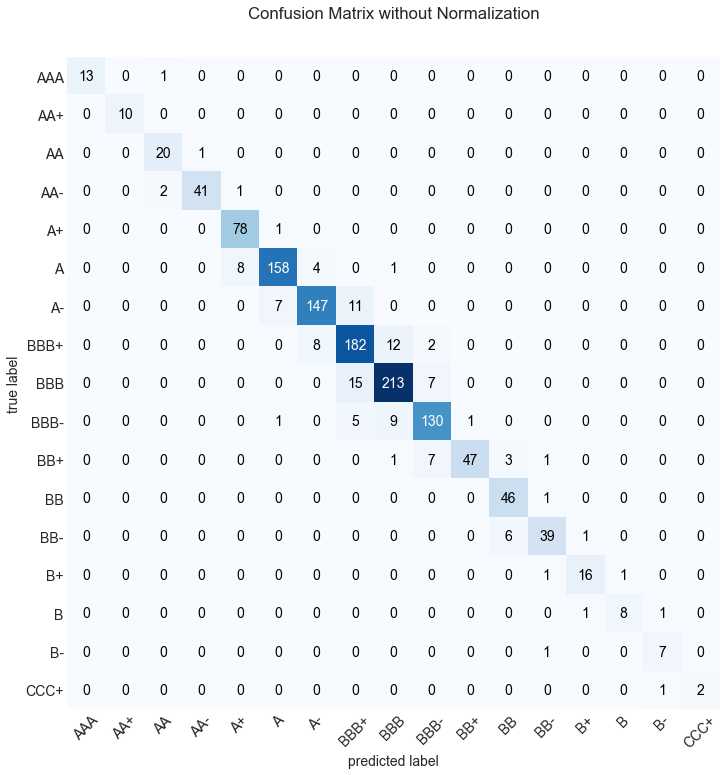

In [38]:
class_names=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+']
cm = confusion_matrix(y_test, y_pred, binary=False)
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_normed=False, class_names=class_names)
ax.set_title('Confusion Matrix without Normalization')
plt.show()

For better interpretation we normalized the confusion matrix. Following confusion matrix shows, that most classifications of random forest are correct. Furthermore, if there are incorrect classifications, the deviation from the true rating is small. We can neither detect high variance nor bias. However, we have ascertained that performance declines for lower ratings, especially for CCC+. We attribute this decrease in performance to lower occurences of low ratings in the data.

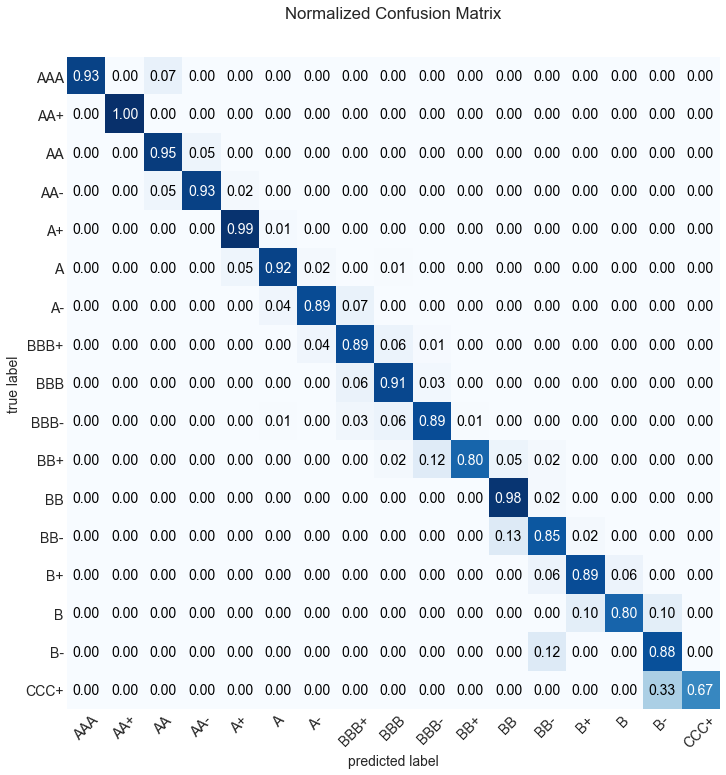

In [39]:
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_absolute=False, show_normed=True, class_names=class_names)
ax.set_title('Normalized Confusion Matrix')
plt.show()

#### Illustrate feature importance
We visualize the feature importance of the random forest classifier. Therefore, we first extract the feature labels and the feature importance attributes.

In [40]:
# Extract feature labels
feat_labels = x.columns.drop('date')

# Extract feature importance attributes
importances = forest.feature_importances_

Now we sort the output by relative importance and print the top 15 features.

In [41]:
indices = np.argsort(importances)[::-1]
n = len(feat_labels)
for i in range(n):
    print('{0:2d}) {1:7s} {2:6.4f}'.format(i + 1, 
                                           feat_labels[indices[i]],
                                           importances[indices[i]]))

 1) ATQ     0.1035
 2) gpm     0.0758
 3) RE_TA_ratio 0.0732
 4) lt_debt 0.0693
 5) cash_conversion 0.0684
 6) cash_lt 0.0682
 7) debt_capital 0.0673
 8) debt_assets 0.0670
 9) MV_BV_ratio 0.0630
10) dpr     0.0621
11) intcov_ratio 0.0618
12) roce    0.0564
13) int_totdebt 0.0561
14) debt_ebitda 0.0546
15) intcov  0.0532


Now we calculate the cumulative sum of the n most important features.

In [42]:
feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

We plot the feature importance of the selected features, both cumulative and on individual level

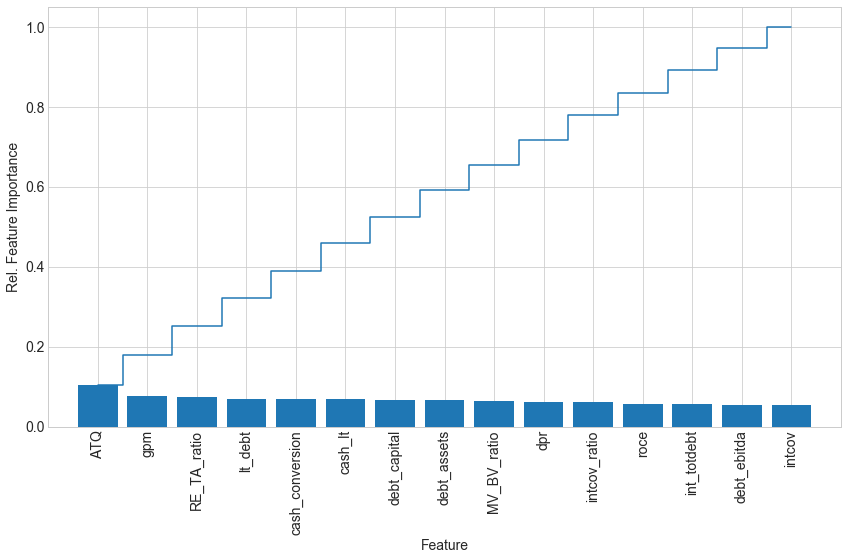

In [43]:
plt.figure(figsize=(12, 8))
plt.bar(range(n), importances[indices[:n]], align='center')
plt.xticks(range(n), feat_labels[indices[:n]], rotation=90)
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Rel. Feature Importance')
plt.step(range(n), sum_feat_imp, where='mid', 
         label='Cumulative importance')
plt.tight_layout();

## Logistic Regression
The second statistical model used is logistic regression, which we as followings.

In [44]:
# Create Pipeline object with LogisticRegression estimator
pipe = Pipeline([('classifier', LogisticRegression(random_state=0, max_iter=2000))])

# Define the hyperparameter values to be tested
param_grid = [{'classifier__C': [250, 300, 350]}] # [100, 200, 300, 350, 400, 500]
   
# Run brute-force grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5, n_jobs=-1)
gs = gs.fit(X_train, y_train.to_numpy())

print('Best CV accuracy: {:.2f}'.format(gs.best_score_))
print('Test score:       {:.2f}'.format(gs.score(X_test, y_test.to_numpy())))
print('Best parameters: {}'.format(gs.best_params_))

Best CV accuracy: 0.33
Test score:       0.33
Best parameters: {'classifier__C': 300}


Using logistic regression, we are only able to correctly classify 33.28% of the test set. 

In [45]:
# Logistic Regression
logReg = LogisticRegression(C=300, max_iter=2000, random_state=0)
logReg.fit(X_train, y_train.to_numpy())
print('Test score: {:.4f}'.format(logReg.score(X_test, y_test.to_numpy())))

Test score: 0.3328


Again, we calculate the $F_1$-score and create a confusion matrix for analysing our results. With a $F_1$-score of 0.3161 logistic regression performs relatively bad for this classification problem.

In [46]:
# Create Confusion matrix
y_pred = logReg.predict(X_test)
confm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confm)

# Create F1-score statistics
print('\nF1-score: {:.4f}'.format(metrics.f1_score(y_test, y_pred, average='weighted')))
print('\n extended:\n', metrics.classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 13   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3   3   0   0   4   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  14   4   0   2   1   0   0   0   0   0   0   0   0   0   0]
 [  1   0   3   7   8  16   3   0   5   0   0   0   1   0   0   0   0]
 [  2   1   9   2  21  26   8   3   7   0   0   0   0   0   0   0   0]
 [  0   3   2   7   7  68  35  25  22   2   0   0   0   0   0   0   0]
 [  0   0   0   0  11  32  31  29  57   2   0   0   3   0   0   0   0]
 [  0   0   0   0   2  16  32  74  76   3   0   0   1   0   0   0   0]
 [  0   0   0   1   1  12  20  42 125  27   3   1   3   0   0   0   0]
 [  0   1   0   1   0   1   9  13  87  28   4   1   1   0   0   0   0]
 [  0   0   0   1   0   0   1   6  37   5   3   3   2   0   0   1   0]
 [  0   0   0   0   0   0   0   0  22  13   3   1   5   3   0   0   0]
 [  0   0   0   0   0   0   1   0  17   2   2   2  20   0   0   2   0]
 [  0   0   0   0   0   0   0   0   3   0   4   0   5   5 

While trying to calculate the $F_1$-score we get a warning message, saying that $F_1$-score and precision are ill-defined and that they are set to 0.0 in label with no predicted samples. We get this message because some labels in y_test do not appear in y_pred. We are not interested in the scores of labels that were not predicted. Therefore, we calculate the $F_1$-score again but now we specify the labels we are actually interested in, which are the labels that were predicted at least once. <br>
Despite a small increase, the resulting $F_1$-score of 0.3169 is still not satisfactory.

In [47]:
print('\nF1-score: {:.4f}'.format(metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))))


F1-score: 0.3169


We change the design of the confusion matrix for better visualization.

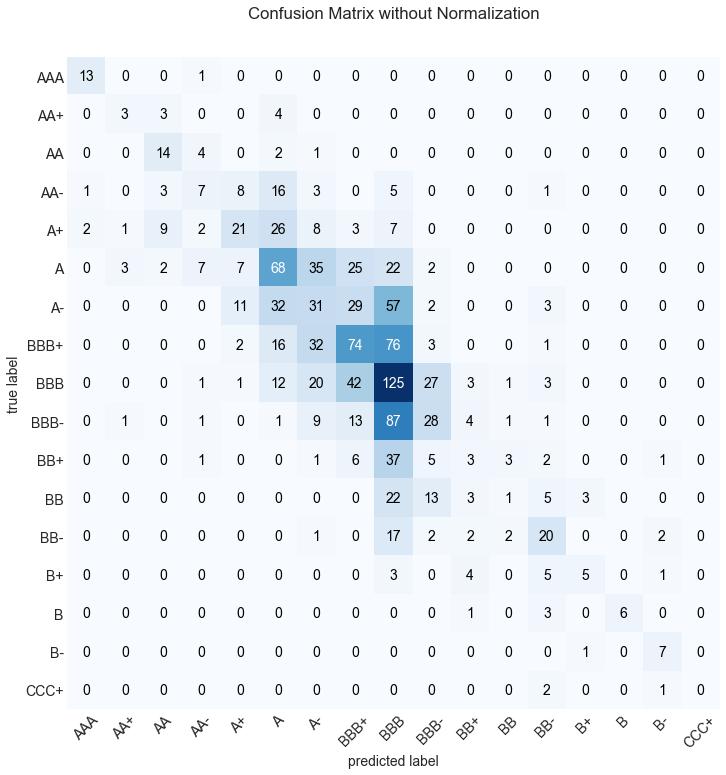

In [48]:
class_names=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+']
cm = confusion_matrix(y_test, y_pred, binary=False)
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_normed=False, class_names=class_names)
ax.set_title('Confusion Matrix without Normalization')
plt.show()

By looking at the normalized confusion matrix, we can see that the results of logistic regression suffer from high variance. 

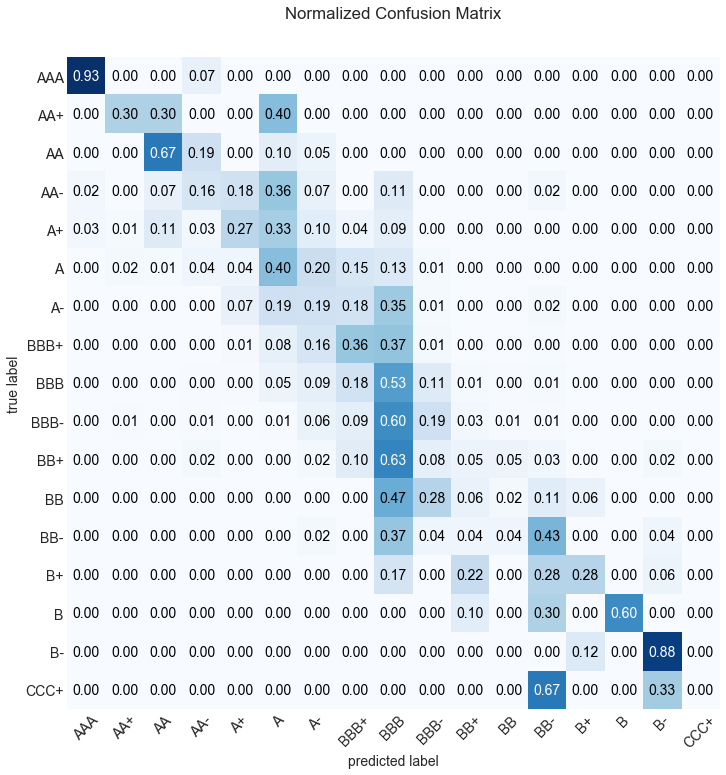

In [49]:
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_absolute=False, show_normed=True, class_names=class_names)
ax.set_title('Normalized Confusion Matrix')
plt.show()

We assume that logistic regression performs poorly because we classify the ratings over 17 groups, while logistic regression was originally developed for binary classification.

## Support Vector Classifier
Third, we implement the support vector classifier as a statistical model we used.

In [50]:
# Create Pipeline object with SVC estimator
pipe = Pipeline([('classifier', SVC(random_state=0))])

# Define the hyperparameter values to be tested
param_grid = [{'classifier__class_weight': [None, 'balanced'], # ['balanced', None]
               'classifier__kernel': ['rbf'], # ['poly', 'rbf', 'sigmoid']
               'classifier__gamma': ['scale', 'auto'], # ['scale', 'auto']
               'classifier__C': [2000], # [1000, 1500, 2000, 2500]
               'classifier__degree': [3]}] # [1, 2, 3, 4, 5, 7]
   
# Run brute-force grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5, n_jobs=-1)
gs = gs.fit(X_train, y_train.to_numpy())

print('Best CV accuracy: {:.2f}'.format(gs.best_score_))
print('Test score:       {:.2f}'.format(gs.score(X_test, y_test.to_numpy())))
print('Best parameters: {}'.format(gs.best_params_))

Best CV accuracy: 0.83
Test score:       0.82
Best parameters: {'classifier__C': 2000, 'classifier__class_weight': None, 'classifier__degree': 3, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


With support vector classifier, 82.27% of the test set is correctly classified.

In [51]:
# SVM
svm = SVC(class_weight=None, kernel='rbf', gamma='auto', C=2000, degree=3, random_state=0)
svm.fit(X_train, y_train.to_numpy())
print('Test score: {:.4f}'.format(svm.score(X_test, y_test.to_numpy())))

Test score: 0.8227


Now we create a confusion matrix and calculate the $F_1$-score. We can see that both precision and recall are high.

In [52]:
# Create Confusion matrix
y_pred = svm.predict(X_test)
confm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confm)

# Create F1-score statistics
print('\nF1-score: {:.4f}'.format(metrics.f1_score(y_test, y_pred, average='weighted')))
print('\n extended:\n', metrics.classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 14   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  19   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2  39   2   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   3  74   1   0   0   0   0   0   0   1   0   0   0   0]
 [  0   1   0   0   7 151   7   5   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   3   8 135  16   1   1   0   0   1   0   0   0   0]
 [  0   0   1   0   0   0  15 174   9   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  20 187  21   3   0   2   0   0   0   0]
 [  0   0   0   0   0   2   3   7  23 105   5   0   1   0   0   0   0]
 [  0   0   0   0   0   0   1   0   9   8  38   1   2   0   0   0   0]
 [  0   0   0   0   0   0   0   1   1   1   2  41   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   1   5  39   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   3   2  12 

We change the design of the confusion matrix for better visualization.

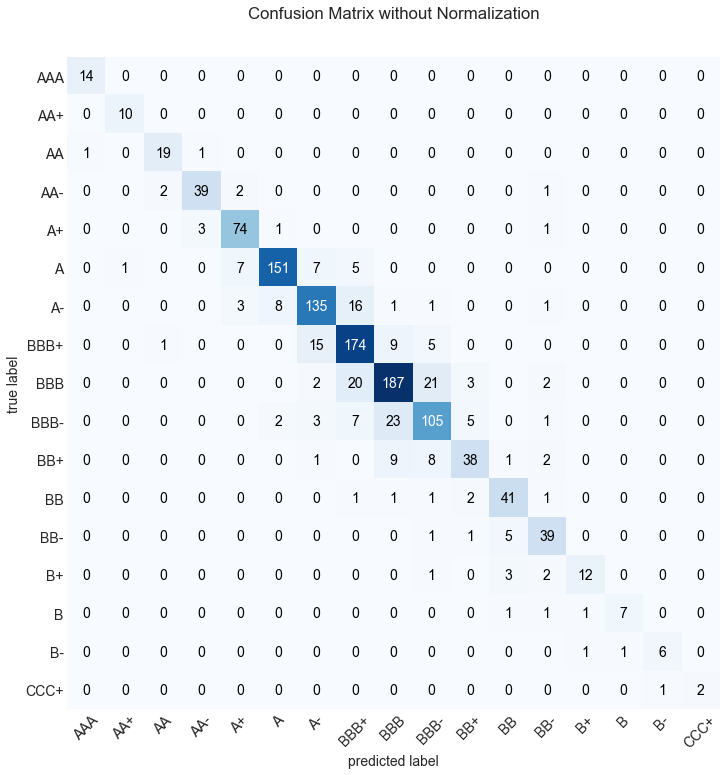

In [53]:
class_names=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+']
cm = confusion_matrix(y_test, y_pred, binary=False)
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_normed=False, class_names=class_names)
ax.set_title('Confusion Matrix without Normalization')
plt.show()

Considering the normalized matrix, we can neither detect high variance nor strong bias. For the lower ratings, the classifications are slightly biased with a tendency of predicting too high ratings.

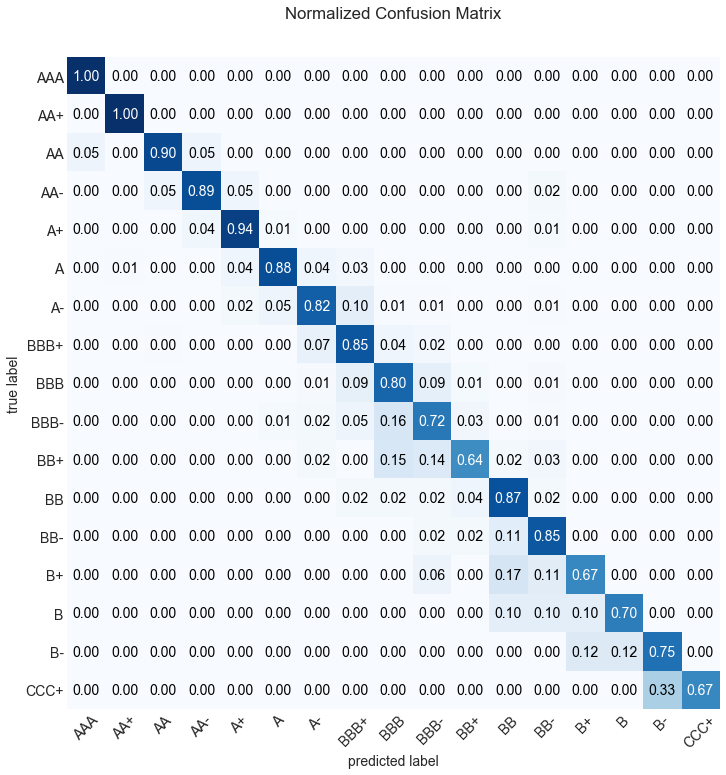

In [54]:
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_absolute=False, show_normed=True, class_names=class_names)
ax.set_title('Normalized Confusion Matrix')
plt.show()

## Neural Networks
Additionally, we implement a densely connected Neural Network with four hidden layers. <br>
<br>
First, we have to create custom mappers for the neural network.

In [55]:
rating_to_number = {
        '01. AAA ': 1,
        '02. AA+ ': 2,
        '03. AA  ': 3,
        '04. AA- ': 4,
        '05. A+  ': 5,
        '06. A   ': 6,
        '07. A-  ': 7,
        '08. BBB+': 8,
        '09. BBB ': 9,
        '10. BBB-':10,
        '11. BB+ ':11,
        '12. BB  ':12,
        '13. BB- ':13,
        '14. B+  ':14,
        '15. B   ':15,
        '16. B-  ':16,
        '17. CCC+':17,
    }

number_to_rating = {
        1: '01. AAA ',
        2: '02. AA+ ',
        3: '03. AA  ',
        4: '04. AA- ',
        5: '05. A+  ',
        6: '06. A   ',
        7: '07. A-  ',
        8: '08. BBB+',
        9: '09. BBB ',
        10: '10. BBB-',
        11: '11. BB+ ',
        12: '12. BB  ',
        13: '13. BB- ',
        14: '14. B+  ',
        15: '15. B   ',
        16: '16. B-  ',
        17: '17. CCC+',
    }

We have to make sure all of them are dataframes. Then, we convert ratings into numbers.

In [56]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train['ratings'] = y_train['ratings'].apply(lambda x: rating_to_number.get(x))
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_test['ratings'] = y_test['ratings'].apply(lambda x: rating_to_number.get(x))

Now we create the input data for the neural network. Basically, we create nodes for each data by removing the array in the arrays. We define the batch size for the train set as 25, because this results in best performance/accuracy results based on our trials.

In [57]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(25)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(25)

We create the model with several layers, which will allow development of patterns in between them. The layers are constructed through trial and error by looking for the best accuracy. 

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1216, activation='relu'),
    tf.keras.layers.Dense(608, activation='relu'),
    tf.keras.layers.Dense(304, activation='relu'),
    tf.keras.layers.Dense(121, activation='relu'),
    # the percentages should add up to one (softmax)
    tf.keras.layers.Dense(19, activation='softmax')
])

Now we compile the model.

In [59]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We use 25 epochs, which based on experience gives the best performance/accuracy compromise. An epoch thereby basically defines the number of times the model should be tested with different splits of the train-split.

In [60]:
history = model.fit(train_dataset, epochs=25, verbose=0, shuffle=True, validation_data=test_dataset)
test_loss,test_acc=model.evaluate(test_dataset)

52/52 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.8297


The neural network is able to correctly classify 83.51% of the test set.

In [61]:
print(f"test accuracy: {test_acc}")

test accuracy: 0.8296874761581421


We can visualize the test and training accuracy history with following code.

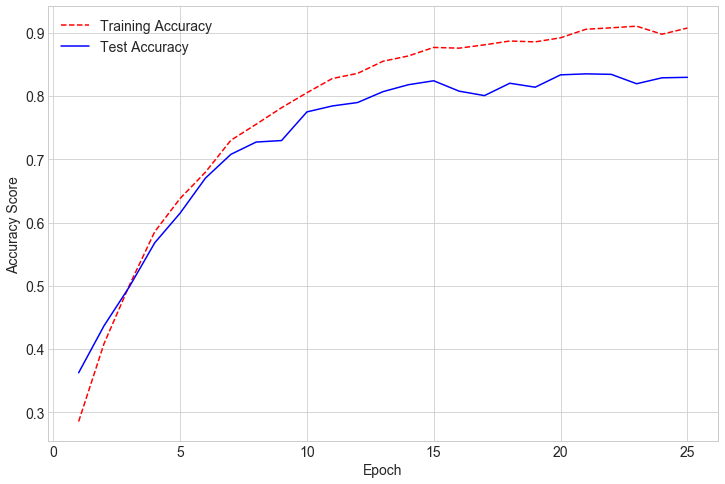

In [62]:
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
epoch_count = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

For further investigations we convert the numbers back to ratings.

In [63]:
y_pred = model.predict(X_test).argmax(axis=1)
y_pred = pd.DataFrame(y_pred, columns=['ratings'])
y_pred['ratings'] = y_pred['ratings'].apply(lambda x: number_to_rating.get(x))
y_test['ratings'] = y_test['ratings'].apply(lambda x: number_to_rating.get(x))

We can now create both confusion matrix and $F_1$-score. We obtain a $F_1$-score of 0.8421 with both high precision and recall.

In [64]:
# Create Confusion matrix
confm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confm)

# Create F1-score statistics
print('\nF1-score: {:.4f}'.format(metrics.f1_score(y_test, y_pred, average='weighted')))
print('\n extended:\n', metrics.classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 13   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   9   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  19   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3  40   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1  73   4   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   5   6 137  18   4   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   0   4 129  30   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  13 181   9   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   2  21 182  24   0   1   2   0   0   0   0]
 [  0   0   0   0   0   0   0   4   6 131   1   2   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   5  45   6   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3  39   0   4   1   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   7  32   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   1  15 

For better visualization, we change the design of the confusion matrix.

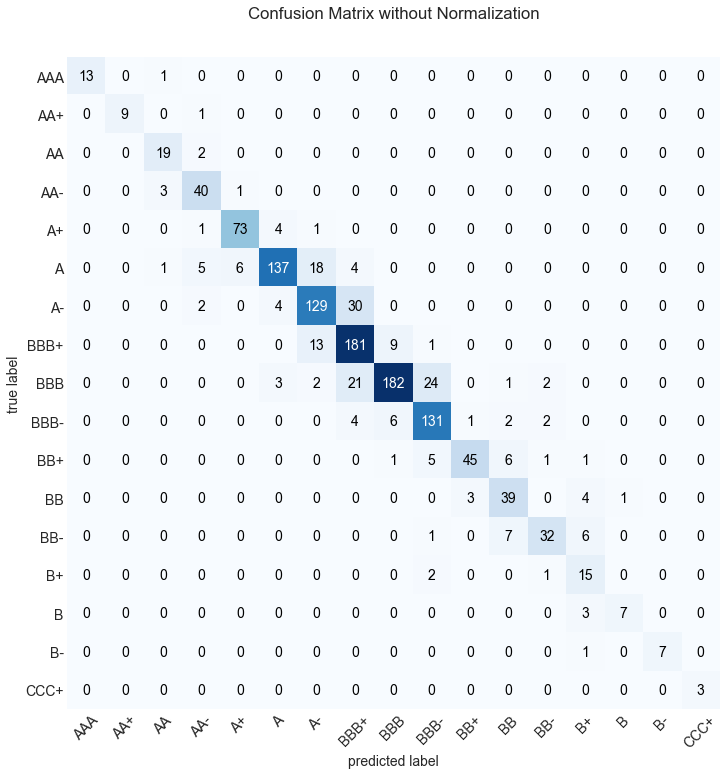

In [65]:
class_names=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+']
cm = confusion_matrix(y_test, y_pred, binary=False)
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_normed=False, class_names=class_names)
ax.set_title('Confusion Matrix without Normalization')
plt.show()

Considering the following normalized confusion matrix, we can say that the results of the neural network implemented suffers neither from high variance nor bias.

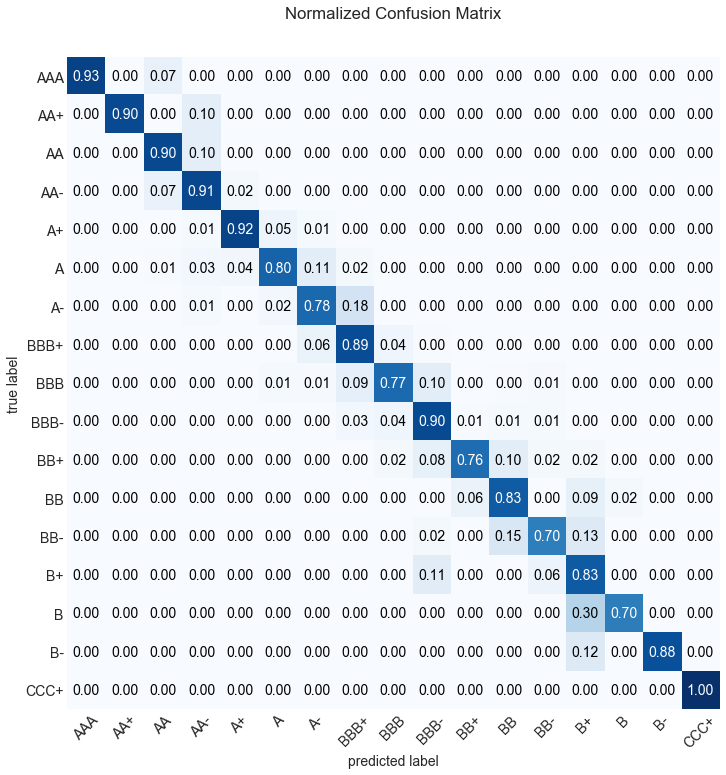

In [66]:
fig, ax = plot_confusion_matrix(cm, figsize=(12,12), colorbar=False, hide_spines=True, show_absolute=False, show_normed=True, class_names=class_names)
ax.set_title('Normalized Confusion Matrix')
plt.show()

## Autoregressive Model
Below code is the attempt to graphically illustrate the issue of conducting a time series analysis on the credit rating data. 
Evendough we have several hunderet observations on the credit rating, the structure of the data does not allow for a regular time series analysis. The reason is that we can not use the credit rating of a paricular firm at time T-1 to predict the rating of another firm at time T. This is because the lag on this particular firm's rating does not contain any ideosyncratic information about future ratings of any other firm in the sample. The best a conventional AR model can do in this case is predict the average credit rating based on the mean of previous quarters.The corresponding series is plotted below, making apparent that this forecast would only be based on 27 observations. In our opinion not enough for a reliable inference.



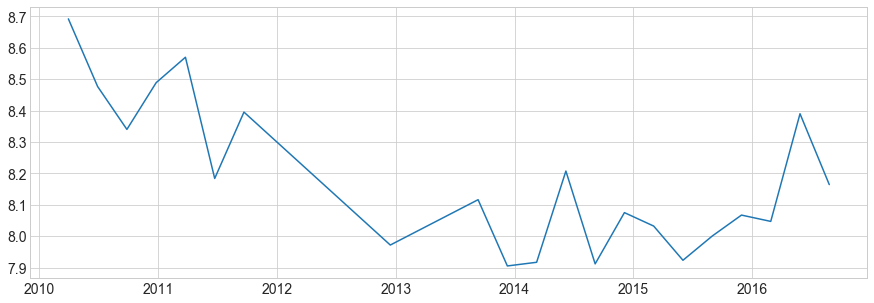

In [67]:
df = pd.read_csv(os.path.join(relative_path_data, __file_ratings_quarterly__), sep=',', parse_dates=__all_parameter_dates__)
x, y = prepare_data(df)
y = y.apply(lambda x: rating_to_number.get(x))
df=pd.DataFrame(x)
df["ratings"]=y

# set date as datetime index
df["date"] = pd.to_datetime(df['date'])
df=df[["date","ratings"]]
df = df.set_index('date')

# calculate 90 days rolling mean
df = df.sort_index()
df["ratings"] = df.rolling('30D',min_periods=1).mean()
df_grouped= df.groupby(pd.Grouper(level='date', freq='90D'))["ratings"].mean()
df_grouped=pd.DataFrame(df_grouped)
df_grouped=df_grouped.dropna()

# plots 90 Days rolling mean 
plt.figure(figsize=(15, 5))
plt.plot(df_grouped.index, df_grouped["ratings"])
plt.show()

The autocorrelation plot shown below suggests that at least four of the lags on the credit rating are significant at a 5% level, despite the limited number of observations. This implies that the inclusion of lags in our model would have merit after all. Nevertheless in order to get a more reliable forecast a vector autoregression would constitute a more viable solution. However for reasons outlined in the latex file (secton "Autoregressive Model") we refrained from implementing such a model.  

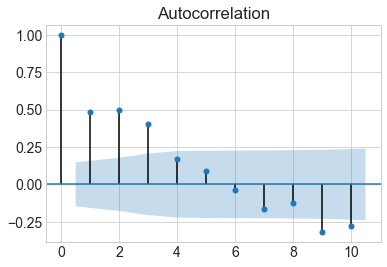

In [68]:
# Calculates autocorrelation functon of the credit rating, to evaluate the predictive power of the lag component.
# The result suggest that four of the lags have significant predictive power.
plt2=smf.plot_acf(df_grouped["ratings"],lags=10,alpha=0.5)
plt2.show()